In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Predictor & group
n_obs = 1000
x_mean = 0
x_sd = 3
x = rng.normal(x_mean, x_sd, n_obs)

n_groups = 3
g = rng.choice(
    [0, 1, 2],
    size = n_obs)

df = pd.DataFrame({"x": x, "g": g})

xarray = xr.DataArray(x, dims = "outcome_dim_0") # For plotting with arviz
xarray = xarray.assign_coords({"outcome_dim_0": np.arange(0, n_obs, 1)})

# Non-group effects
true_intercept = 0 
true_slope = 2
pooled_line = true_intercept + true_slope * x

# Group effects
group_intercepts = [-0.5, 0.1, 0]
group_slopes = [-2, 0.25, 0]
true_mu = df.apply(
    lambda row: (true_intercept + group_intercepts[int(row["g"])]) + (true_slope + group_slopes[int(row["g"])]) * row["x"],
    axis = 1)

garray = xr.DataArray(g, dims = "outcome_dim_0") # For plotting with arviz
garray = garray.assign_coords({"outcome_dim_0": np.arange(0, n_obs, 1)})

# Target
noise_sd = 3
noise = rng.normal(0, noise_sd, n_obs)
df["y"] = true_mu + noise

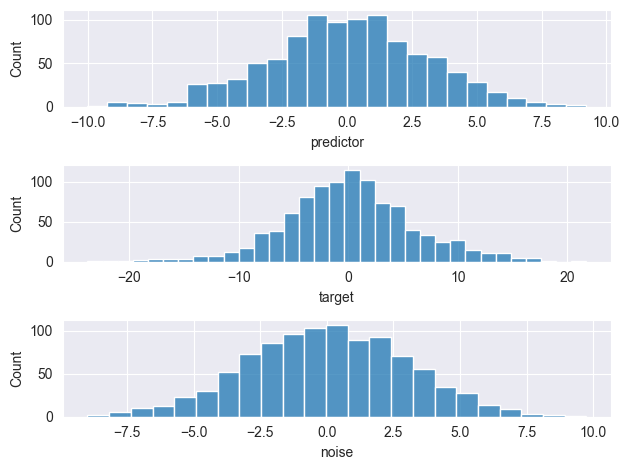

In [5]:
# Distributions of data
fig, ax = plt.subplots(3)

_ = sns.histplot(x, ax = ax[0])
_ = ax[0].set_xlabel("predictor")

_ = sns.histplot(df["y"], ax = ax[1])
_ = ax[1].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[2])
_ = ax[2].set_xlabel("noise")

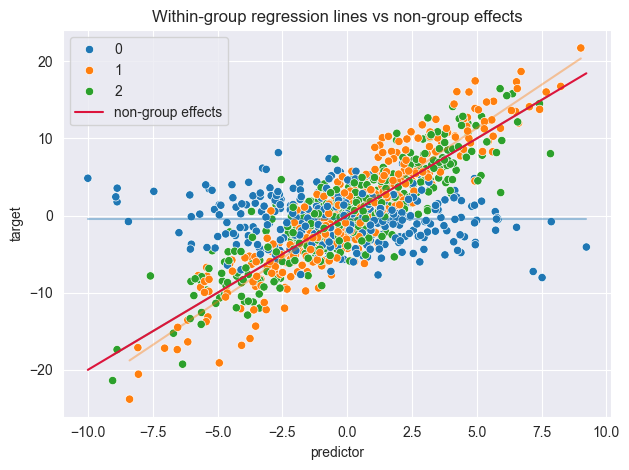

In [6]:
# True regression line vs. groupings in the data
_ = sns.scatterplot(
    data = df, 
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #legend = None
)
_ = sns.lineplot(
    x = x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    alpha = 0.4,
    hue_order = ["0", "1", "2"],
    legend = None
)
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", 
    color = "crimson"
)
_ = plt.title("Within-group regression lines vs non-group effects")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

Group 0 displays no relationship. 1 is fairly close to the non-group relationship, 2 is identical. 

## Pooled

In [7]:
# Create model
pooled_model = pm.Model()

In [8]:
# Define priors & likelihood
with pooled_model:

    # Priors
    intercept = pm.Normal("intercept", mu = 0, sigma = 3) 
    slope = pm.Normal("slope", mu = 0, sigma = 3)
    error = pm.HalfNormal("error", sigma = 5)

    # Expected value & link
    mean = intercept + slope * x

    # Likelihood
    likelihood = pm.Normal(
        "outcome", 
        mu = mean, 
        sigma = error, 
        observed = df["y"])

In [9]:
# Sample from the prior
with pooled_model:
    pooled_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


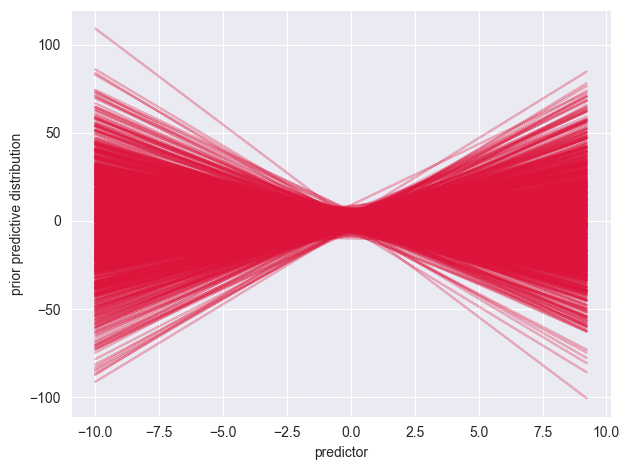

In [10]:
# Prior predictive check
y_pooled_prior = pooled_prior.prior["intercept"] + (pooled_prior.prior["slope"] * xarray)
y_pooled_prior = y_pooled_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_pooled_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [11]:
# Draw posterior samples
with pooled_model:
    pooled_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [12]:
# Sample from posterior
with pooled_model:
    pm.sample_posterior_predictive(pooled_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


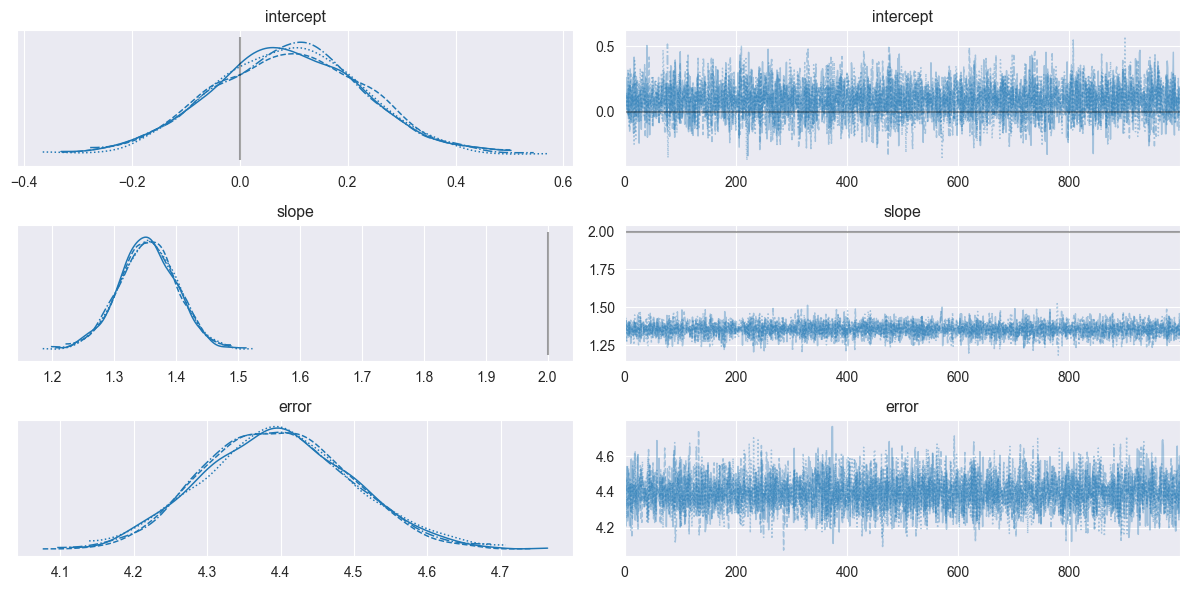

In [13]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    pooled_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

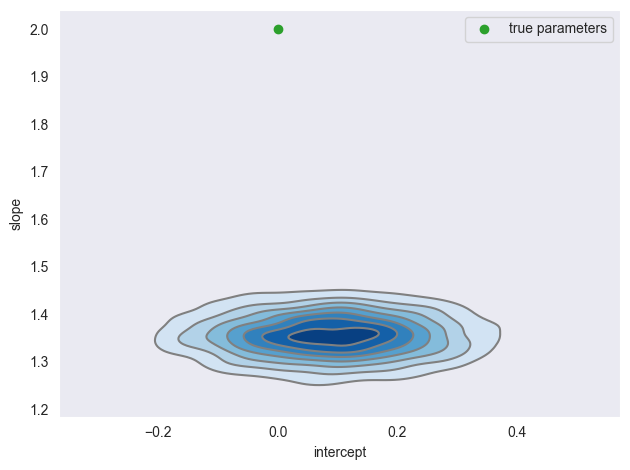

In [14]:
# Parameter space plots
_ = az.plot_kde(
    az.extract(pooled_posterior, var_names="intercept"),
    az.extract(pooled_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

In [15]:
# Simulate fitted regression lines
pooled_fitted = pooled_posterior.posterior["intercept"] + pooled_posterior.posterior["slope"] * xarray

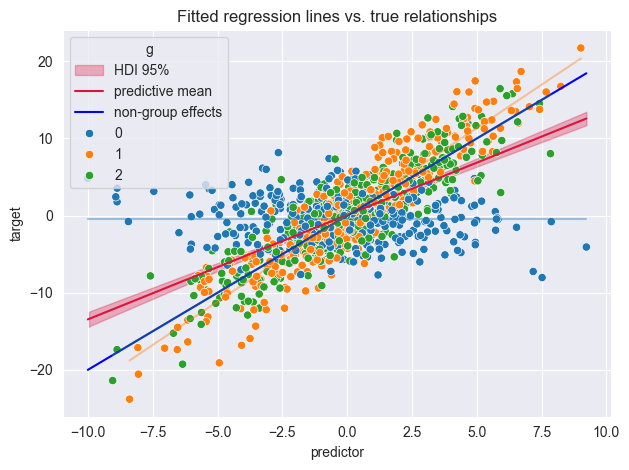

In [16]:
# Plot fitted vs. actual relationship

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray,
    pooled_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(pooled_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df,
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #label = "observed data", 
    #color = "crimson"
)

# True regression lines
_ = sns.lineplot(
    x = x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted regression lines vs. true relationships")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

The fixed slope estimate is pretty good, fixed intercept is way off. Even more so than a smaller sample size. Likely because the noise & the group differences are more pronounced now.

## Random intercepts

In [17]:
# Create model
randint_model = pm.Model(coords = {"group": np.unique(g)})

In [18]:
# Define priors & likelihood
with randint_model:

    # Group indices
    group_ids = pm.MutableData("group_id", g, dims = "obs_id")

    # Fixed effects
    intercept = pm.Normal("intercept", mu = 0, sigma = 3) 
    slope = pm.Normal("slope", mu = 0, sigma = 3)
    error = pm.HalfNormal("error", sigma = 5)

    # Random intercepts
    mu_random = pm.Normal("mu_random", mu = 0, sigma = 3)
    sigma_random = pm.HalfNormal("sigma_random", sigma = 3)

    ## Centered parametrization, causes divergence issues
    #random_intercept = pm.Normal("random_intercept", mu = mu_random, sigma = sigma_random, dims = "group")

    # Non-centered parametrization
    z_random = pm.Normal("z_random", mu = 0, sigma = 1, dims = "group")
    random_intercept = pm.Deterministic(
        "random_intercept", 
        mu_random + (sigma_random * z_random),
        dims = "group"
    )
    
    # Expected value & link
    mean = (intercept + slope * x) + random_intercept[group_ids]

    # Likelihood
    likelihood = pm.Normal(
        "outcome", 
        mu = mean, 
        sigma = error, 
        observed = df["y"],
        dims = "obs_id")

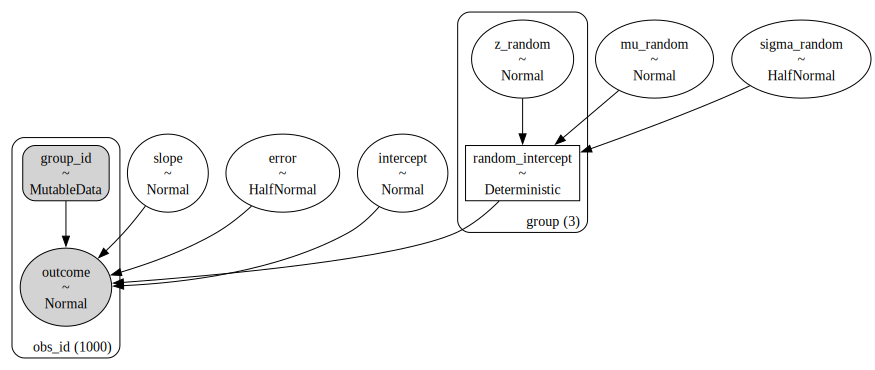

In [19]:
# View model diagram
pm.model_to_graphviz(randint_model)

In [20]:
# Sample from the prior
with randint_model:
    randint_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


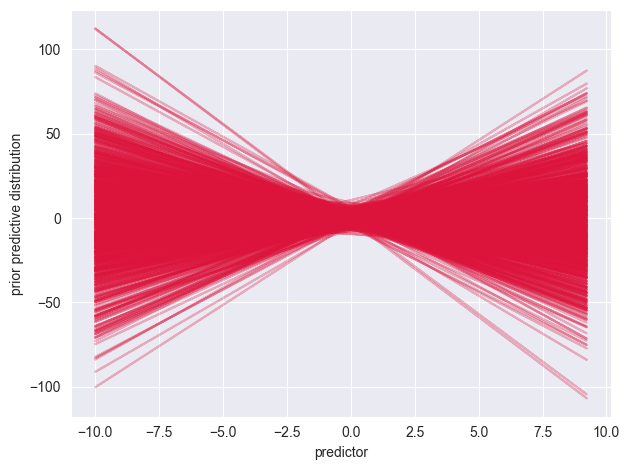

In [21]:
# Prior predictive check
y_randint_prior = randint_prior.prior["intercept"] + (randint_prior.prior["slope"] * xarray)
y_randint_prior = y_randint_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_randint_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [22]:
# Draw posterior samples
with randint_model:
    randint_posterior = pm.sample(
        target_accept = 0.9 # A value closer to 1 can eliminate divergences by shortening the MC's step size. Doesn't always work. Default is 0.8
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error, mu_random, sigma_random, z_random]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [23]:
# Sample from posterior
with randint_model:
    pm.sample_posterior_predictive(randint_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


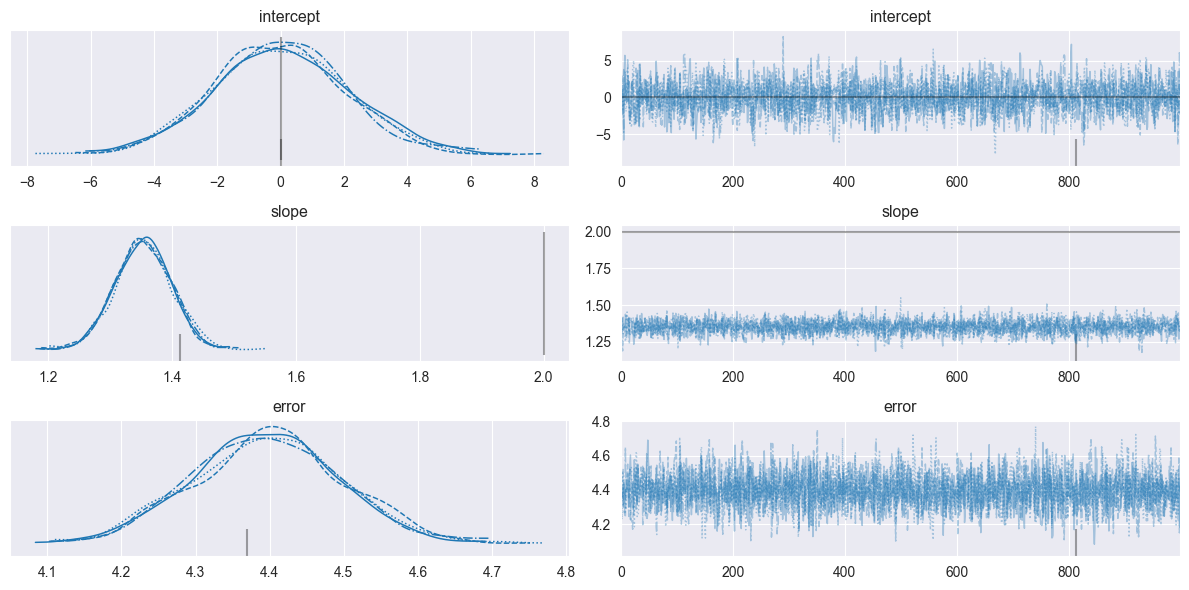

In [24]:
# Plot distribution & sampling chains for fixed effects
_ = az.plot_trace(
    randint_posterior,
    var_names = ["intercept", "slope", "error"],
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

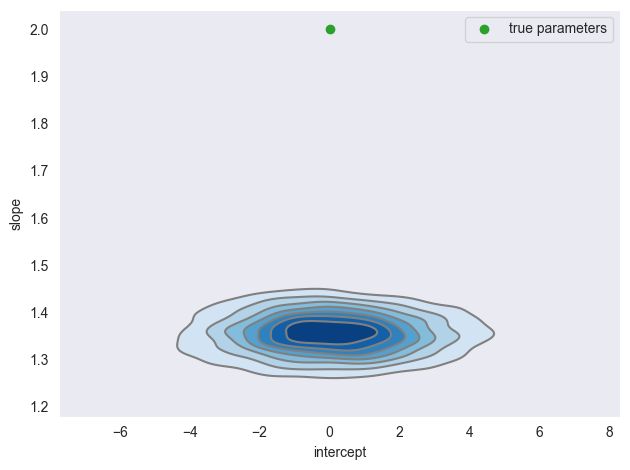

In [25]:
# Parameter space plot
_ = az.plot_kde(
    az.extract(randint_posterior, var_names="intercept"),
    az.extract(randint_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

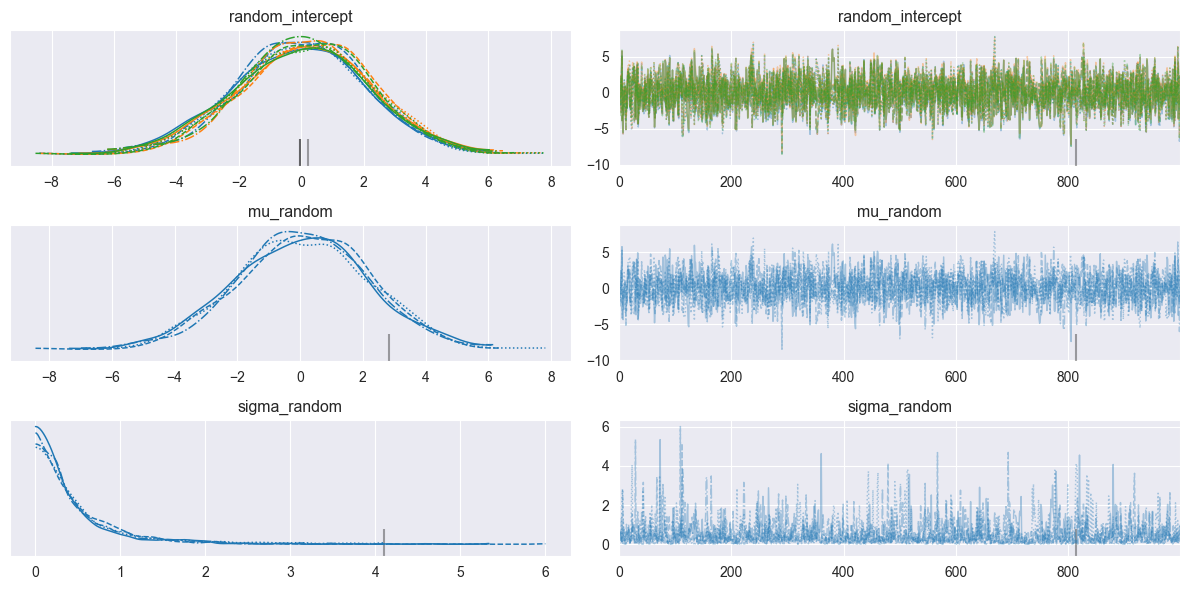

In [26]:
# Plot distribution & sampling chains for random effects
_ = az.plot_trace(
    randint_posterior,
    var_names = [
        "random_intercept", "mu_random", "sigma_random", 
        #"z_random"
    ] 
)

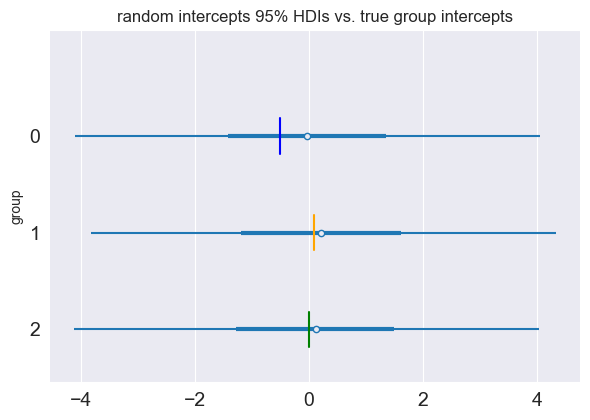

In [27]:
# Plot distribution for random effects
_ = pm.plot_forest(
    randint_posterior,
    var_names=["random_intercept"],
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    hdi_prob = 0.95
    #kind = "ridgeplot",
    #ridgeplot_alpha = 0.3
)
_ = plt.axvline(group_intercepts[0], ymin = 0.65, ymax = 0.75, c = "blue")
_ = plt.axvline(group_intercepts[1], ymin = 0.375, ymax = 0.475,  c = "orange")
_ = plt.axvline(group_intercepts[2], ymin = 0.1, ymax = 0.2,  c = "green")
_ = plt.title("random intercepts 95% HDIs vs. true group intercepts")
_ = plt.ylabel("group")

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


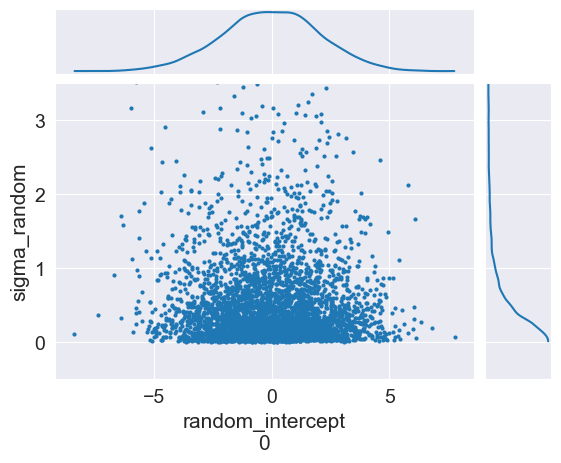

In [28]:
# Plot one random intercept vs. the standard deviation to see if the support is fully sampled
_ = az.plot_pair(
    randint_posterior,
    var_names = ["random_intercept", "sigma_random"],
    coords = {"group" : [0]},
    marginals = True
)
_ = plt.ylim(-0.5, 3.5)

In [29]:
# Simulate fitted regression lines
randint_fitted = randint_posterior.posterior["intercept"] + randint_posterior.posterior["slope"] * xarray

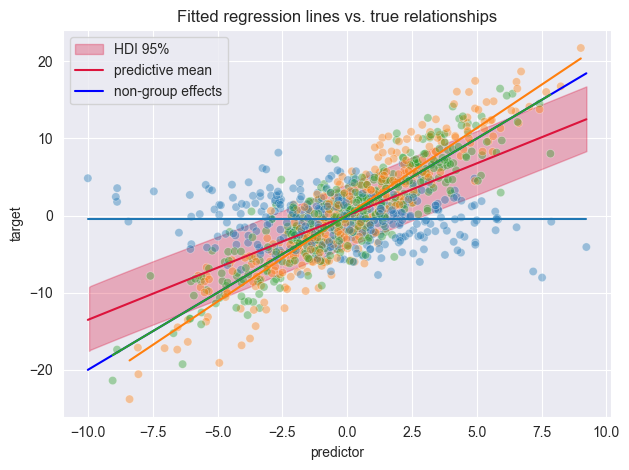

In [30]:
# Plot fitted vs. actual relationship, fixed effects only

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray,
    randint_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(randint_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df,
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

# True regression lines for each group
_ = sns.lineplot(
    x = x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted regression lines vs. true relationships")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

Can't find the true fixed effects without a random slope. Even worse than with a small sample size.

In [31]:
# Get the fitted regression lines for each group
randint_posterior0 = randint_posterior.posterior.where(randint_posterior.posterior.group == 0).mean("group")
randint_fitted0 = randint_posterior0.intercept + randint_posterior0.slope * xarray.where(garray == 0, drop = True) + randint_posterior0.random_intercept

randint_posterior1 = randint_posterior.posterior.where(randint_posterior.posterior.group == 1).mean("group")
randint_fitted1 = randint_posterior1.intercept + randint_posterior1.slope * xarray.where(garray == 1, drop = True) + randint_posterior1.random_intercept

randint_posterior2 = randint_posterior.posterior.where(randint_posterior.posterior.group == 2).mean("group")
randint_fitted2 = randint_posterior2.intercept + randint_posterior2.slope * xarray.where(garray == 2, drop = True) + randint_posterior2.random_intercept

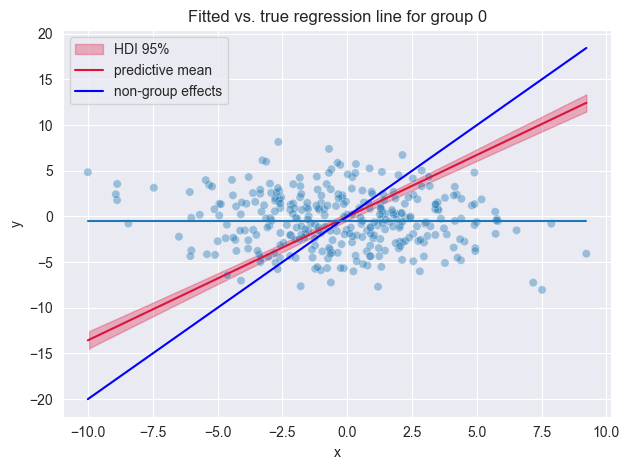

In [32]:
# Plot the fitted regression lines for group 0

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray.where(garray == 0, drop = True),
    randint_fitted0,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(xarray.where(garray == 0, drop = True)), 
    y = np.sort(randint_fitted0.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df[df["g"] == 0],
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    legend = None,
    alpha = 0.4,
    #label = "observed data", 
    #color = "crimson"
)


# True regression line
_ = sns.lineplot(
    x = df[df["g"] == 0].x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted vs. true regression line for group 0")

The random intercept alone is not useful to adjust for the very different relationship in Group 0.

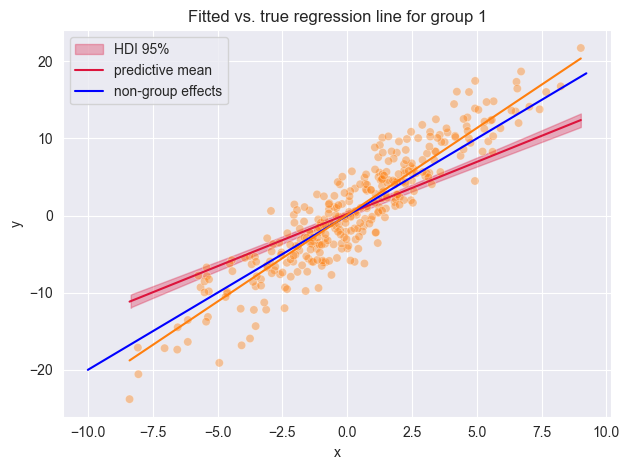

In [33]:
# Plot the fitted regression lines for group 1

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray.where(garray == 1, drop = True),
    randint_fitted1,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(xarray.where(garray == 1, drop = True)), 
    y = np.sort(randint_fitted1.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df[df["g"] == 1],
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

# True regression line
_ = sns.lineplot(
    x = df[df["g"] == 1].x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted vs. true regression line for group 1")

The random intercept does move Group 1's fitted regression line quite a bit, but without a random slope, it can't match the true group effect.

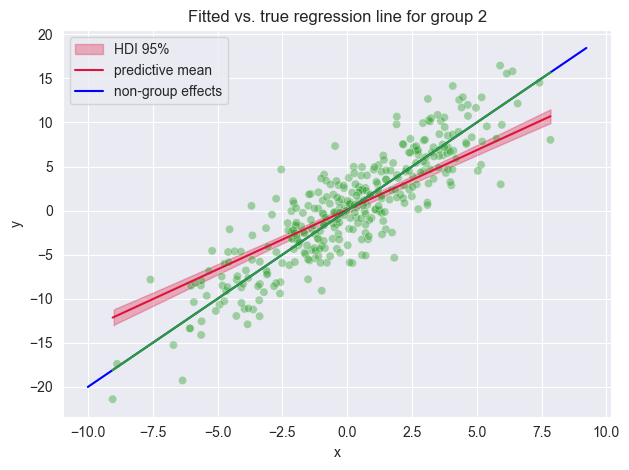

In [34]:
# Plot the fitted regression lines for group 2

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray.where(garray == 2, drop = True),
    randint_fitted2,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(xarray.where(garray == 2, drop = True)), 
    y = np.sort(randint_fitted2.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df[df["g"] == 2],
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

# True regression line
_ = sns.lineplot(
    x = df[df["g"] == 2].x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted vs. true regression line for group 2")

## Random intercepts & slopes

In [35]:
# Create model
random_model = pm.Model(coords = {"group": np.unique(g)})

In [36]:
# Define priors & likelihood
with random_model:

    # Group indices
    group_ids = pm.MutableData("group_id", g, dims = "obs_id")

    # Fixed effects
    intercept = pm.Normal("intercept", mu = 0, sigma = 3) 
    slope = pm.Normal("slope", mu = 0, sigma = 3)
    error = pm.HalfNormal("error", sigma = 5)

    # Random intercepts
    mu_random = pm.Normal("mu_random", mu = 0, sigma = 3)
    sigma_random = pm.HalfNormal("sigma_random", sigma = 3)
    z_random = pm.Normal("z_random", mu = 0, sigma = 1, dims = "group")
    random_intercept = pm.Deterministic(
        "random_intercept", 
        mu_random + (sigma_random * z_random),
        dims = "group"
    )

    # Random slopes
    mu_slope = pm.Normal("mu_slope", mu = 0, sigma = 3)
    sigma_slope = pm.HalfNormal("sigma_slope", sigma = 3)
    z_slope = pm.Normal("z_slope", mu = 0, sigma = 1, dims = "group")
    random_slope = pm.Deterministic(
        "random_slope", 
        mu_slope + (sigma_slope * z_slope),
        dims = "group"
    )

    # Expected value & link
    mean = (intercept + random_intercept[group_ids]) + ((slope + random_slope[group_ids]) * x)

    # Likelihood
    likelihood = pm.Normal(
        "outcome", 
        mu = mean, 
        sigma = error, 
        observed = df["y"],
        dims = "obs_id")

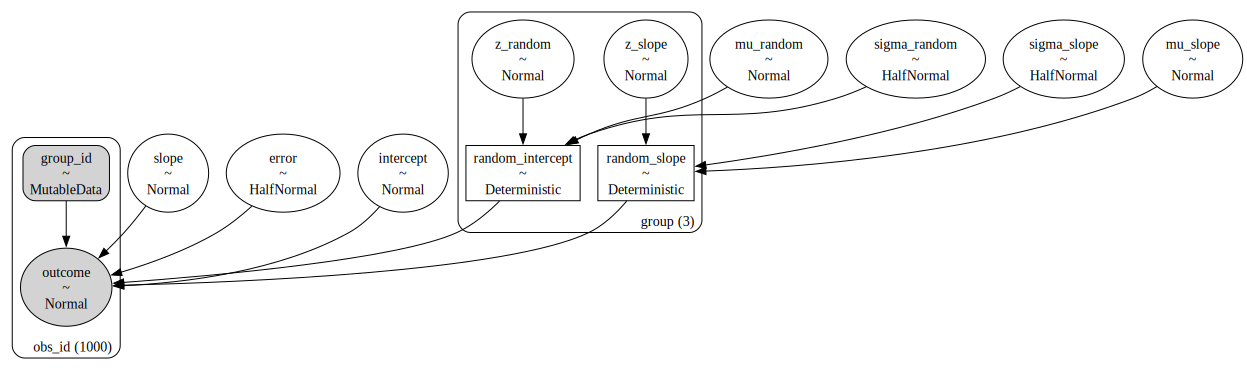

In [37]:
# View model diagram
pm.model_to_graphviz(random_model)

In [38]:
# Sample from the prior
with random_model:
    random_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


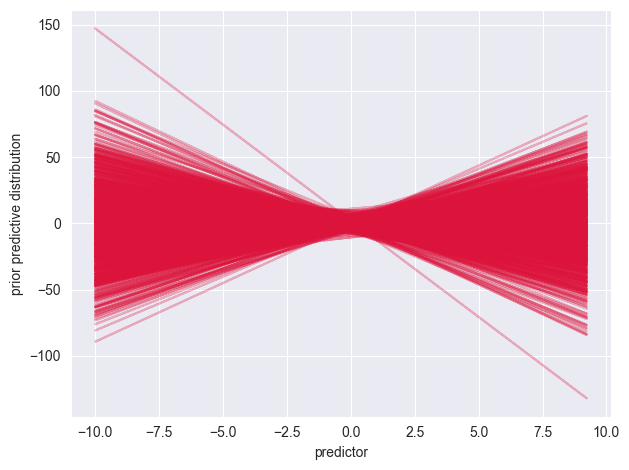

In [39]:
# Prior predictive check
y_random_prior = random_prior.prior["intercept"] + (random_prior.prior["slope"] * xarray)
y_random_prior = y_random_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_random_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [40]:
# Draw posterior samples
with random_model:
    random_posterior = pm.sample(target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, error, mu_random, sigma_random, z_random, mu_slope, sigma_slope, z_slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [41]:
# Sample from posterior
with random_model:
    pm.sample_posterior_predictive(random_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


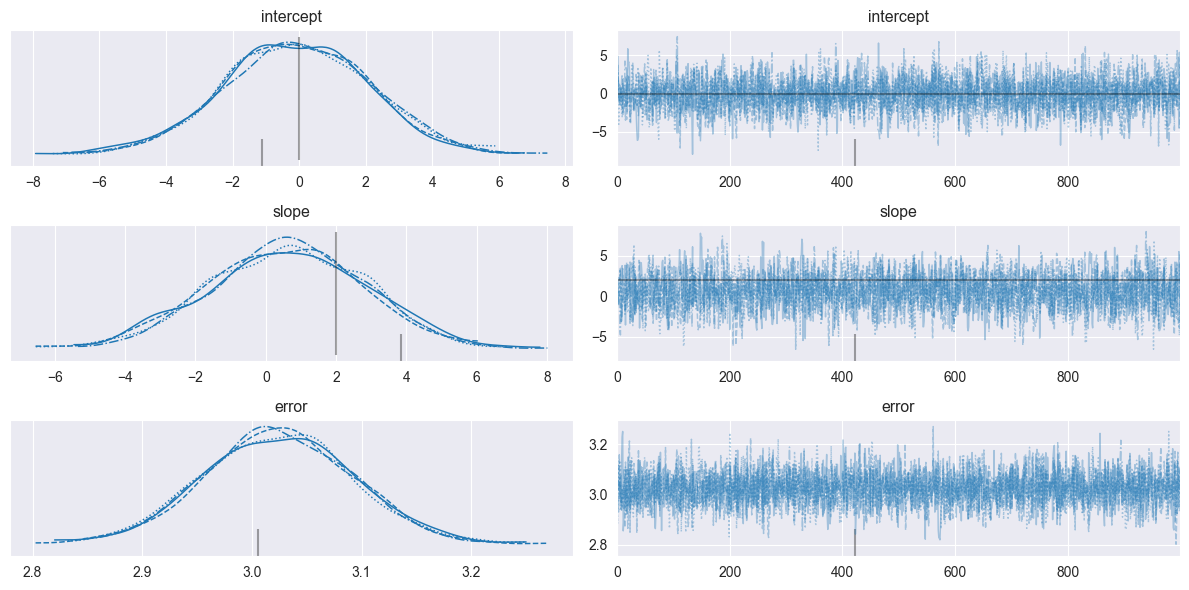

In [42]:
# Plot distribution & sampling chains for fixed effects
_ = az.plot_trace(
    random_posterior,
    var_names = ["intercept", "slope", "error"],
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

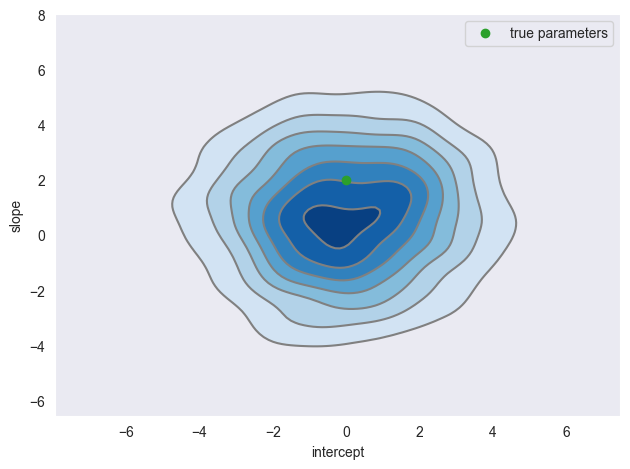

In [43]:
# Parameter space plot
_ = az.plot_kde(
    az.extract(random_posterior, var_names="intercept"),
    az.extract(random_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

Best fixed effect estimates so far.

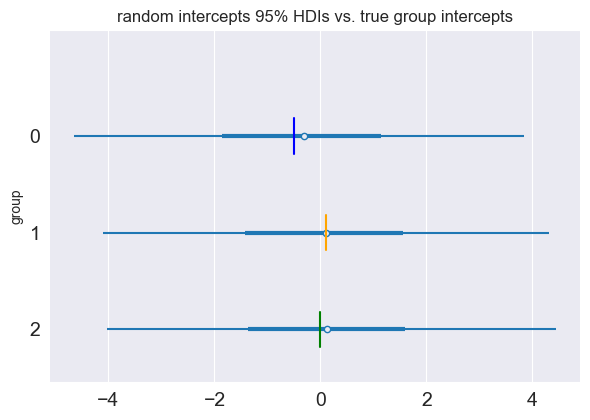

In [44]:
# Plot distribution for random intercepts
_ = pm.plot_forest(
    random_posterior,
    var_names=["random_intercept"],
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    hdi_prob = 0.95
    #kind = "ridgeplot",
    #ridgeplot_alpha = 0.3
)
_ = plt.axvline(group_intercepts[0], ymin = 0.65, ymax = 0.75, c = "blue")
_ = plt.axvline(group_intercepts[1], ymin = 0.375, ymax = 0.475,  c = "orange")
_ = plt.axvline(group_intercepts[2], ymin = 0.1, ymax = 0.2,  c = "green")
_ = plt.title("random intercepts 95% HDIs vs. true group intercepts")
_ = plt.ylabel("group")

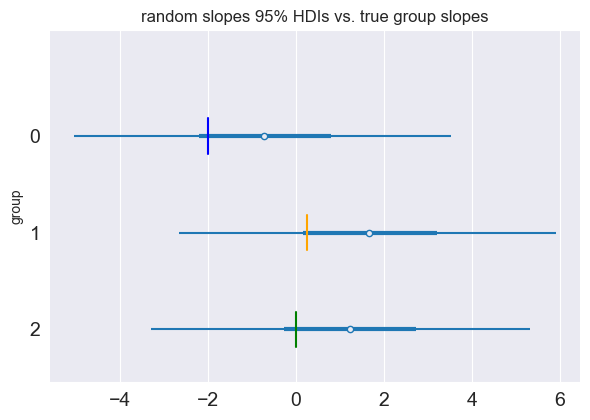

In [45]:
# Plot distribution for random slopes
_ = pm.plot_forest(
    random_posterior,
    var_names=["random_slope"],
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    hdi_prob = 0.95
    #kind = "ridgeplot",
    #ridgeplot_alpha = 0.3
)
_ = plt.axvline(group_slopes[0], ymin = 0.65, ymax = 0.75, c = "blue")
_ = plt.axvline(group_slopes[1], ymin = 0.375, ymax = 0.475,  c = "orange")
_ = plt.axvline(group_slopes[2], ymin = 0.1, ymax = 0.2,  c = "green")
_ = plt.title("random slopes 95% HDIs vs. true group slopes")
_ = plt.ylabel("group")

The random slope estimates are not very good.

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


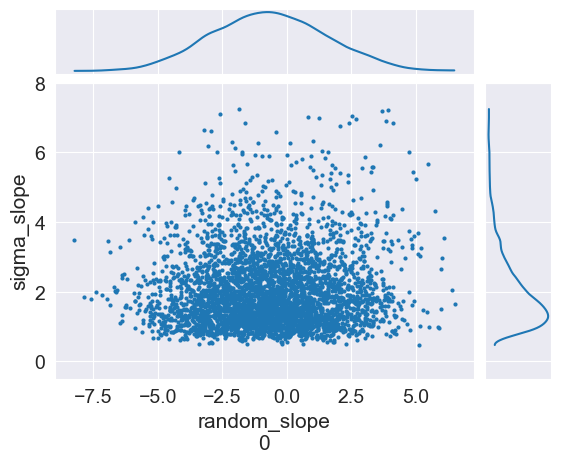

In [46]:
# Plot one random slope vs. the standard deviation to see if the support is fully sampled
_ = az.plot_pair(
    random_posterior,
    var_names = ["random_slope", "sigma_slope"],
    coords = {"group" : [0]},
    marginals = True
)
_ = plt.ylim(-0.5, 8)

The support for the random slope's standard deviation prior is not sampled close to 0, despite the non-centered parametrization.

In [47]:
# Simulate fitted regression lines
random_fitted = random_posterior.posterior["intercept"] + random_posterior.posterior["slope"] * xarray

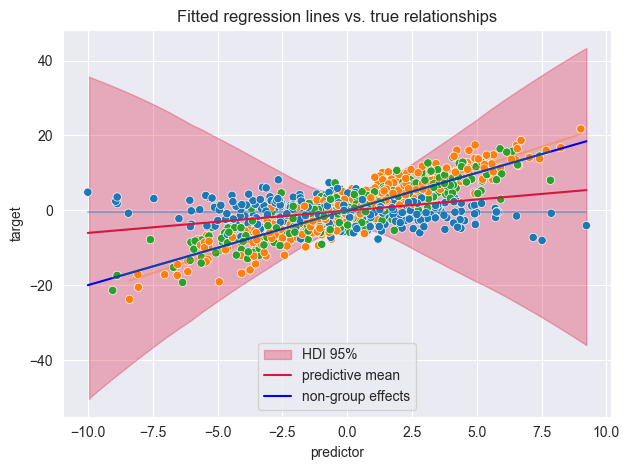

In [48]:
# Plot fitted vs. actual relationship, fixed effects only

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray,
    random_fitted,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(x), 
    y = np.sort(random_fitted.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df,
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

# True regression lines for each group
_ = sns.lineplot(
    x = x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted regression lines vs. true relationships")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

The HDI for the fixed effects is broad in sparse areas of the data, and narrow in dense areas. The predictive mean is way off from the true fixed effects.

In [49]:
# Get the fitted regression lines for each group
random_posterior0 = random_posterior.posterior.where(random_posterior.posterior.group == 0).mean("group")
random_fitted0 = (random_posterior0.intercept + random_posterior0.random_intercept) + ((random_posterior0.slope + random_posterior0.random_slope) * xarray.where(garray == 0, drop = True))

random_posterior1 = random_posterior.posterior.where(random_posterior.posterior.group == 1).mean("group")
random_fitted1 = (random_posterior1.intercept + random_posterior1.random_intercept) + ((random_posterior1.slope + random_posterior1.random_slope) * xarray.where(garray == 1, drop = True))

random_posterior2 = random_posterior.posterior.where(random_posterior.posterior.group == 2).mean("group")
random_fitted2 = (random_posterior2.intercept + random_posterior2.random_intercept) + ((random_posterior2.slope + random_posterior2.random_slope) * xarray.where(garray == 2, drop = True))

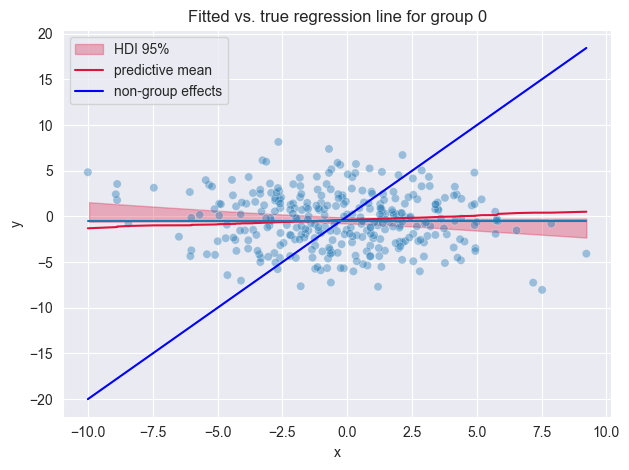

In [50]:
# Plot the fitted regression lines for group 0

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray.where(garray == 0, drop = True),
    random_fitted0,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(xarray.where(garray == 0, drop = True)), 
    y = np.sort(random_fitted0.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df[df["g"] == 0],
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    legend = None,
    alpha = 0.4,
    #label = "observed data", 
    #color = "crimson"
)


# True regression line
_ = sns.lineplot(
    x = df[df["g"] == 0].x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted vs. true regression line for group 0")

The fitted line for Group 0 tries to come close to the true group regression line. The slope is still off. Better than with a smaller sample size.

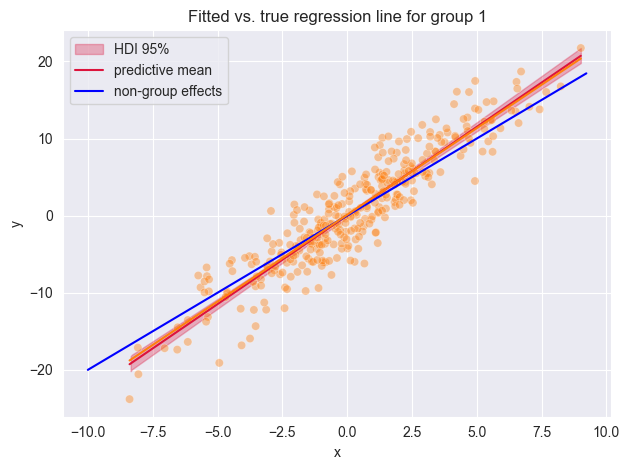

In [51]:
# Plot the fitted regression lines for group 1

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray.where(garray == 1, drop = True),
    random_fitted1,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(xarray.where(garray == 1, drop = True)), 
    y = np.sort(random_fitted1.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df[df["g"] == 1],
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

# True regression line
_ = sns.lineplot(
    x = df[df["g"] == 1].x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted vs. true regression line for group 1")

Group 1's fitted regression line is very close to the real one.

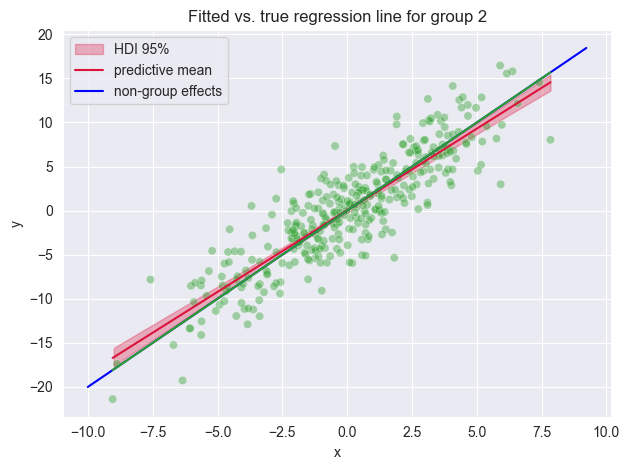

In [52]:
# Plot the fitted regression lines for group 2

# Highest density interval for fitted regression lines
_ = az.plot_hdi(
    xarray.where(garray == 2, drop = True),
    random_fitted2,
    fill_kwargs = {"alpha": 0.3, "label": "HDI 95%", "color": "crimson"},
    hdi_prob = .95
)

# Mean of fitted regression lines
_ = sns.lineplot(
    x = np.sort(xarray.where(garray == 2, drop = True)), 
    y = np.sort(random_fitted2.mean(("chain", "draw")).values), 
    label = "predictive mean", color = "crimson")

# True regression line, fixed effects only
_ = sns.lineplot(
    x = x, 
    y = pooled_line, 
    label = "non-group effects", color = "blue")

# True observations
_ = sns.scatterplot(
    data = df[df["g"] == 2],
    x = "x", 
    y = "y", 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

# True regression line
_ = sns.lineplot(
    x = df[df["g"] == 2].x, 
    y = true_mu, 
    hue = df["g"].astype(str),
    hue_order = ["0", "1", "2"],
    #alpha = 0.4,
    legend = None
    #label = "observed data", 
    #color = "crimson"
)

_ = plt.title("Fitted vs. true regression line for group 2")

Group 2's regression line is estimated a bit worse compared to a smaller sample size.